In [1]:
#import all required libraries etc

from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import itertools

#run notebook with functions we'll need
%run ./Lab2_2020_functions.ipynb

In [2]:
#run stepwise regression function
#NOTE: stepwise_selection function used from: 
#https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
#         print(excluded)
        new_pval = pd.Series(index=excluded, dtype = 'float64')
        for new_column in excluded:
#             print(included, new_column)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
#             print(best_feature, included)
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(X.columns[worst_feature], worst_pval))
        if not changed:
            break
    return included

In [128]:
### PREP DATA ###

## MANUAL INPUT START ##
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/PRISMA_spots.csv'
data = pd.read_csv(target_file, header = 0, index_col = 0) 
sensor_meta = pd.read_csv('PRISMA_meta.csv', header = 0, index_col = None)


bad_bands_idx = np.r_[230:234] # choose bands to drop by index
#bad_ages = ['3.37', '16.48','78.5'] # choose fan ages to drop, e.g. fan Ya
#data = data.drop(bad_ages, axis=1) 

# extract variables from dataset and save, drop and prep for PCA
age_sd = list(data.T['age_sd'])
age_n = list(data.T['age_n'])
data = data.T.drop(['age_sd', 'age_n'], axis = 1)

## MANUAL INPUT END ##
ages = list(data.index.values.astype(float)) # save ages as an array for plotting
ages = np.round(ages, 2) # round age array 
data.iloc[:,bad_bands_idx] = 0 # band bands as 0 for PCA`
data = data.T.reset_index(drop = True)

band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

# prep data fro MLR

#data = ((data - data.mean())/data.std())
data = data.dropna(axis=1) # drop columns whichcontain NaN
data = data.T.reset_index(drop = True)

age = pd.DataFrame(ages)
# create training and testing dataset

data_test = data[[0]]
data = data.drop(labels = [0], axis = 0)

age_test = age.loc[0]
age = age.drop(labels = [0], axis = 0)

y_train = age
X_train = data # drop columns whichcontain NaN

y_test = age_test
X_test = data_test
# check

In [129]:
lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X_train,y_train)
ypred_MLR = lm_MLR.predict(X_train) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X_train,y_train) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
print('a2 = ' + str(coef_MLR[1]))
print('a3 = ' + str(coef_MLR[2]))
print('a4 = ' + str(coef_MLR[3]))
print('a5 = ' + str(coef_MLR[4]))
print('a6 = ' + str(coef_MLR[5]))
print('etc...')
R2_MLR

MLR results:
a0 = [467.86858673]
a1 = [ 5.05329190e+00  9.85354980e+01  3.74583629e+02  1.10995403e+03
 -7.76963427e+02 -1.85094820e+03 -3.97652963e+02 -1.39409621e+02
  3.87643469e+02 -1.63135057e+02 -9.74686482e+01  3.18399791e+02
  9.80377232e+01 -6.99230579e+02  6.82665207e+02 -3.10581647e+02
 -8.69123497e+02 -7.73453579e+02 -1.33459076e+03 -1.27803749e+03
 -7.88549795e+02 -9.60426585e+02 -9.08254687e+02 -9.30035993e+02
 -6.34859940e+02  5.49694001e+02 -7.14077867e+01  5.35444017e+02
  4.92569177e+02  4.35495826e+02  3.60284169e+02  9.62430723e+02
  5.90121922e+02  8.45889089e+02  5.52768374e+02  6.69357997e+02
  3.68028399e+02  2.58337312e+02 -1.99356317e+02 -1.69394451e+03
 -8.51485378e+02 -8.26298506e+01 -2.07116822e+02 -2.57373627e+03
 -4.83538254e+02 -5.35563038e+02 -2.19694363e+01  3.93312324e+02
 -2.71227291e+02 -1.61120584e+02  2.25521772e+02  3.05047586e+02
  2.49078936e+02  8.87391377e+01  6.93600912e+02  8.20311844e+02
  8.11284498e+02  9.56929097e+02  2.07075441e+03  3.

IndexError: index 1 is out of bounds for axis 0 with size 1

ValueError: x and y must be the same size

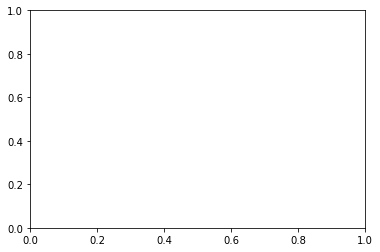

In [150]:
np.shape

0    0.0
Name: 0, dtype: float64


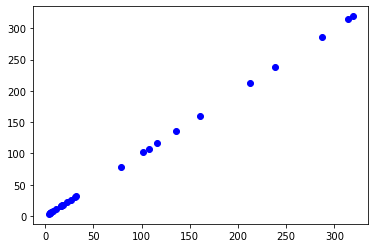

In [130]:
age_mod = lm_MLR.predict(X_train)

#age_mod_test = lm_MLR.predict(X_test)

plt.scatter(y_train, age_mod, c = 'blue')
#plt.scatter(y_test, age_mod_test, c = 'red')

#print(age_mod_test)
print(y_test)

In [131]:
import warnings
warnings.filterwarnings('ignore')
#now, use stepwise regression to find which predictors to use

result = stepwise_selection(X_train, y_train)

print('resulting features:')
print(result)

Add                               0 with p-value 0.00022281
Add                              58 with p-value 0.000513867
resulting features:
[0, 58]


stepwise MLR results:
a0 = [293.1161292]
a1 = [-7296.96334921  2581.63725029]


Text(0.5, 1.0, 'MLR data')

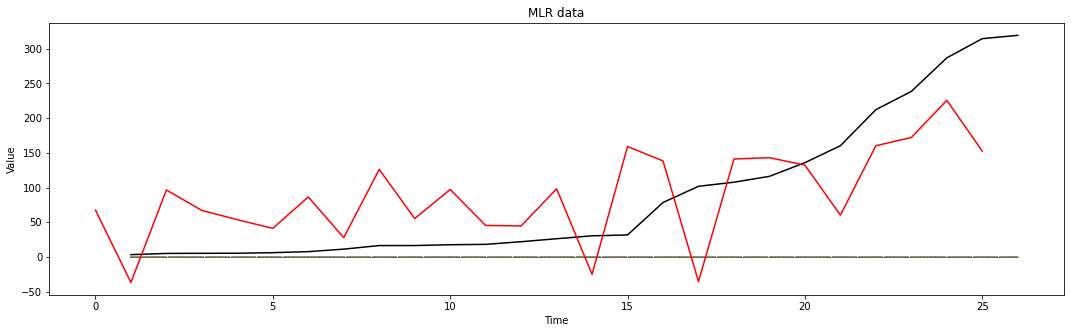

In [132]:
#do MLR using predictors chosen from stepwise regression
lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X_train[result],y_train)
ypred_step = lm_step.predict(X_train[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X_train[result],y_train) #R-squared value from MLR model

print('stepwise MLR results:')
print('a0 = ' + str(intercept_step))
print('a1 = ' + str(coef_step[0]))
#print('a2 = ' + str(coef_step[1]))
#print('a3 = ' + str(coef_step[2]))

#visualize model (ADD y pred to legend!)

plt.figure(figsize=[40,5])

plt.subplot(1,2,1)
plt.plot(X_train, '--', linewidth = 0.7)
plt.plot(y_train, color = 'black')
plt.plot(ypred_step, color = 'red')
#plt.legend(X + y)
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('MLR data')

In [72]:
result[0]

'2159.2878'

In [133]:
a0 =  intercept_step
a1 = coef_step[0]
a2 =coef_step[1]
a3 = coef_step[2]

x1 = X_train[result[0]]
x2 = X_train[result[1]]
x3 = X_train[result[2]]

age_mod = a1*x1 + a2*x2 + a3*x3 + a0

x1_test = X_test[result[0]]
x2_test = X_test[result[1]]
x3_test = X_test[result[2]]

age_mod_test = a1*x1_test + a2*x2_test + a3*x3_test + a0

plt.scatter(y_train, age_mod, c = 'blue')
plt.scatter(y_test, age_mod_test, c = 'red')

print(age_mod_test)
print(y_test)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [185]:
#load the data and check it out
data = pd.read_csv('prisma_crs_MLR.csv')
age = data['age']
data = data.drop(['age'], axis = 1)
names = data.columns
#normalize data and check it out
data = ((data - data.mean())/data.std())

data.head()

,402.4402,411.3164,419.3725,426.9674,434.3084,441.6589,449.0336,456.3773,463.731,470.9489,...,2407.3386,2414.1565,2420.9873,2428.4001,2435.3269,2442.1877,2448.9236,2456.3296,2462.813,2469.4155
0,NaN,0.518408,0.825841,0.880763,1.166920,1.365999,1.283478,1.198478,1.058769,1.021751,...,-1.136405,-1.026819,0.309065,0.039222,-0.280010,-0.429627,-1.018336,0.717409,0.360307,NaN
1,NaN,0.312938,-0.219383,0.038627,-0.646533,-0.566582,0.093221,0.293357,0.463938,0.469078,...,0.327004,1.073372,-1.298958,-1.407720,-1.047343,-0.265180,1.178246,-1.526111,0.360307,NaN
2,NaN,0.730008,0.834922,0.890697,0.963795,1.273866,1.422370,1.492120,1.358019,1.206416,...,-0.269683,-0.253698,-0.104953,0.894096,0.225675,1.219951,-0.334789,-0.092994,0.360307,NaN
3,NaN,0.609924,0.794242,0.706371,0.939956,0.860722,0.775893,0.457870,0.410038,0.397040,...,-0.975140,-1.031942,0.528900,-0.330082,-0.328238,-0.681287,-1.226100,1.010403,0.360307,NaN
4,NaN,0.844942,0.884229,0.885223,0.558308,0.198235,0.112954,0.139576,0.256383,0.032777,...,-0.887392,-0.777421,-1.203251,-1.097189,-0.933458,0.222507,-0.319456,-0.869453,0.360307,NaN


In [186]:
y = age
X = data.dropna(axis=1) # drop columns whichcontain NaN

Text(0.5, 1.0, 'MLR data')

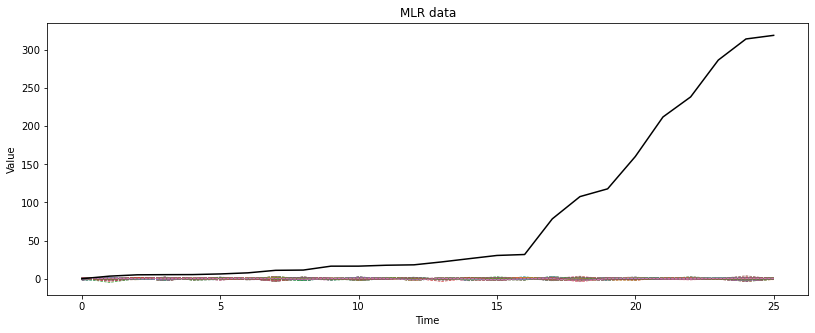

In [187]:

plt.figure(figsize=[30,5])

plt.subplot(1,2,1)
plt.plot(X, '--', linewidth = 0.7)
plt.plot(y, color = 'black')
#plt.legend(X + y)
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('MLR data')


In [188]:
lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X,y)
ypred_MLR = lm_MLR.predict(X) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X,y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
print('a2 = ' + str(coef_MLR[1]))
print('a3 = ' + str(coef_MLR[2]))
print('a4 = ' + str(coef_MLR[3]))
print('a5 = ' + str(coef_MLR[4]))
print('a6 = ' + str(coef_MLR[5]))
print('etc...')
R2_MLR

MLR results:
a0 = 79.62669140161293
a1 = 21.672759231884918
a2 = 11.25203909302121
a3 = 10.967837253776798
a4 = 6.212382805345829
a5 = -13.818322161657356
a6 = -25.153260861258477
etc...


1.0

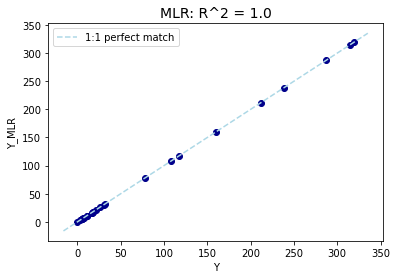

In [189]:
fs = 14
ax1 = plt.subplot(111)
ax1.scatter(y,ypred_MLR, c = 'darkblue')
l1 = np.min(ax1.get_xlim())
l2 = np.max(ax1.get_xlim())
ax1.plot([l1,l2], [l1,l2], ls="--", c="lightblue", label = "1:1 perfect match")
plt.xlabel('Y')
plt.ylabel('Y_MLR')
plt.title('MLR: R^2 = ' + str(R2_MLR)[:5], fontsize = fs)
plt.legend()

plt.show()

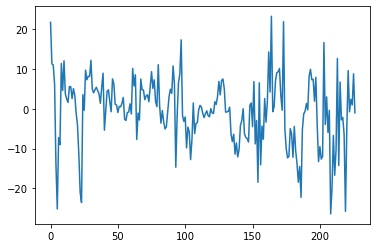

In [200]:

plt.plot(coef_MLR)


In [139]:
import warnings
warnings.filterwarnings('ignore')
#now, use stepwise regression to find which predictors to use

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Add  2159.2878                      with p-value 0.00012316
Add  972.6346                       with p-value 0.000623622
Add  1822.1488                      with p-value 0.000105863
resulting features:
['2159.2878', '972.6346', '1822.1488']


In [140]:
#do MLR using predictors chosen from stepwise regression
lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X[result],y)
ypred_step = lm_step.predict(X[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X[result],y) #R-squared value from MLR model

print('stepwise MLR results:')
print('a0 = ' + str(intercept_step))
print('a1 = ' + str(coef_step[0]))
print('a2 = ' + str(coef_step[1]))
print('a3 = ' + str(coef_step[2]))


stepwise MLR results:
a0 = 79.62669140161223
a1 = -146.15492716834046
a2 = 72.25179886803842
a3 = -64.57862091963216


In [141]:
#which predictor is most important?
print('Most important variable index for stepwise: ', np.argmax(np.abs(coef_step)))

print('Most important variable for stepwise: ', result[np.argmax(np.abs(coef_step))])

print(result)
print(coef_step)

Most important variable index for stepwise:  0
Most important variable for stepwise:  2159.2878
['2159.2878', '972.6346', '1822.1488']
[-146.15492717   72.25179887  -64.57862092]


In [178]:
test = np.array(result)
test.astype(float)

array([2159.2878,  972.6346, 1822.1488])

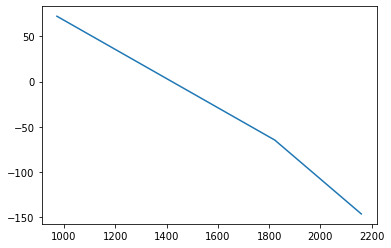

In [184]:
test = pd.DataFrame()
test['x'] = np.array(result).astype(float)
test['coef'] = coef_step
test = test.sort_values(by=['x'])
plt.plot(test['x'],test['coef'])


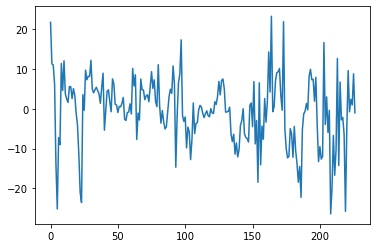

In [203]:
x = [2159.2878, 972.6346, 1822.1488]
plt.plot(coef_MLR)


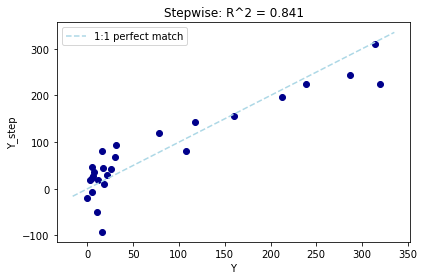

In [151]:
ax2 = plt.subplot(111)
ax2.scatter(y,ypred_step, c = 'darkblue')
l1 = np.min(ax2.get_xlim())
l2 = np.max(ax2.get_xlim())
ax2.plot([l1,l2], [l1,l2], ls="--", c="lightblue", label = "1:1 perfect match")
plt.xlabel('Y')
plt.ylabel('Y_step')
plt.legend()
plt.title('Stepwise: R^2 = ' + str(R2_step)[:5], fontsize = fs)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'MLR data')

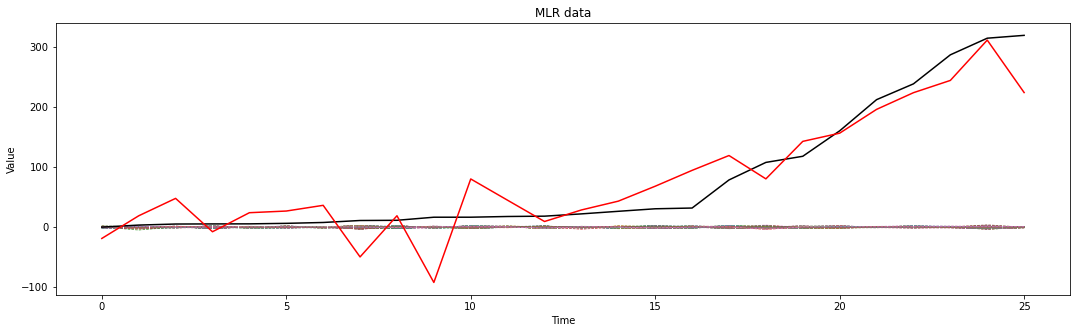

In [152]:
#visualize model (ADD y pred to legend!)

plt.figure(figsize=[40,5])

plt.subplot(1,2,1)
plt.plot(X, '--', linewidth = 0.7)
plt.plot(y, color = 'black')
plt.plot(ypred_step, color = 'red')
#plt.legend(X + y)
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('MLR data')

(0.0, 35.0)

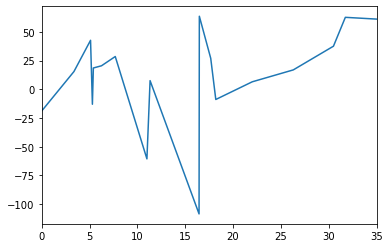

In [210]:
test = ypred_step- y
plt.plot(age, test)

In [204]:
import warnings
warnings.filterwarnings('ignore')
#MLR, stepwise, and MLR with kept predictors

#MLR
lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X,y)
ypred_MLR = lm_MLR.predict(X) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X,y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
print('a2 = ' + str(coef_MLR[1]))
print('a3 = ' + str(coef_MLR[2]))
print('a4 = ' + str(coef_MLR[3]))
print('')

#stepwise
print('Stepwise results:')
result = stepwise_selection(X, y,threshold_in=0.05,threshold_out=0.1)

print('Resulting features:')
print(result)

lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X[result],y)
ypred_step = lm_step.predict(X[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X[result],y) #R-squared value from MLR model

MLR results:
a0 = 79.62669140161293
a1 = 21.672759231884918
a2 = 11.25203909302121
a3 = 10.967837253776798
a4 = 6.212382805345829

Stepwise results:
Add  2159.2878                      with p-value 0.00012316
Add  972.6346                       with p-value 0.000623622
Add  1822.1488                      with p-value 0.000105863
Resulting features:
['2159.2878', '972.6346', '1822.1488']


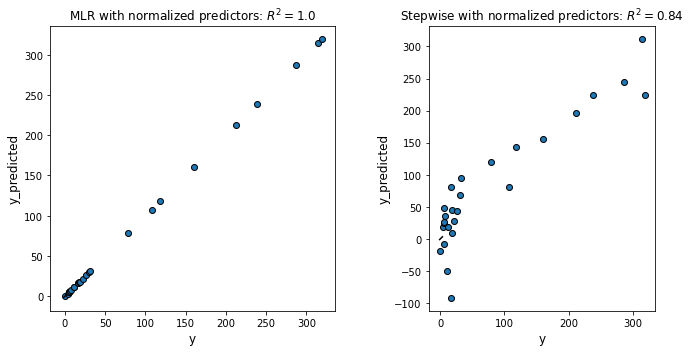

In [205]:
saveIt = 0
fs = 12
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

axes[0].scatter(y, ypred_MLR, edgecolor = 'k')
axes[0].plot([-2,4],[-2,4],'k--')
axes[0].set_xlabel('y', fontsize = fs)
axes[0].set_ylabel('y_predicted', fontsize = fs)
axes[0].set_title('MLR with normalized predictors: $R^2 = $' + str(np.round(R2_MLR, decimals = 2)), fontsize = fs)
axes[0].set_aspect('equal')
axes[0].tick_params(labelsize = fs-2)

axes[1].scatter(y, ypred_step, edgecolor = 'k')
axes[1].plot([-2,4],[-2,4],'k--')
axes[1].set_xlabel('y', fontsize = fs)
axes[1].set_ylabel('y_predicted', fontsize = fs)
axes[1].set_title('Stepwise with normalized predictors: $R^2 = $' + str(np.round(R2_step, decimals = 2)), fontsize = fs)
axes[1].set_aspect('equal')
axes[1].tick_params(labelsize = fs-2)

plt.tight_layout()

if saveIt:
    plt.savefig('example5_fig3.png', dpi = 300, bbox_inches = 'tight')

In [146]:
#which predictor is most important?
print('Most important variable index for MLR: ', np.argmax(np.abs(coef_MLR)))
print('Most important variable index for stepwise: ', np.argmax(np.abs(coef_step)))
print()
print('Most important variable for MLR: ', X.columns[np.argmax(np.abs(coef_MLR))])
print('Most important variable for stepwise: ', result[np.argmax(np.abs(coef_step))])

Most important variable index for MLR:  208
Most important variable index for stepwise:  0

Most important variable for MLR:  2335.2361
Most important variable for stepwise:  2159.2878


In [147]:
#make MLR model, fit to the data, and predict y

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X,y)
ypred_MLR = lm_MLR.predict(X) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X,y) #R-squared value from MLR model

Text(0.5, 1.0, 'MLR Model Results: R^2 = 1.0')

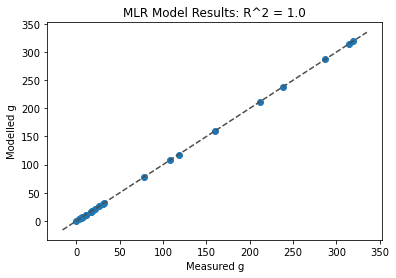

In [148]:
#visualize MLR model performance

ax = plt.subplot(111)
ax.scatter(y,ypred_MLR)
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured g')
plt.ylabel('Modelled g')
plt.title('MLR Model Results: R^2 = ' + str(R2_MLR)[:4])

In [ ]:
#use stepwise regression to find which predictors to use

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

In [ ]:
#do MLR using predictors chosen from stepwise regression

lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X[result],y)
ypred_step = lm_step.predict(X[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X[result],y) #R-squared value from MLR model

In [ ]:
#visualize stepwise model performance

ax = plt.subplot(111)
ax.scatter(y,ypred_step)
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured g')
plt.ylabel('Modelled g')
plt.title('Stepwise Model Results: R^2 = ' + str(R2_step)[:4])
plt.show()

In [ ]:
#goal: loop through every combination of normalized predictors, make linear model, and find one with best performance

R2_best = []
combo_best = []

for kk in range(1,10): #for each total number of predictors to use in model (from 1 predictor to 9 predictors)
    
    v0 = range(np.shape(X)[1])
    combinations = list(itertools.combinations(range(np.shape(X)[1]),kk)) #all possible combinations of kk total predictors 
    R2_test = []
    
    for ind in range(len(combinations)): #for each combination of predictors, make MLR model and compute R^2

        test_vars = np.array(combinations[ind])
        X_test = X.iloc[::2,test_vars]  # calibation sample consists of all odd indices in the data
        y_test = y.iloc[::2]
        
        X_valid = X.iloc[1::2,test_vars]  # validation sample consists of all even indices in the data
        y_valid = y.iloc[1::2]

        lm_test = linear_model.LinearRegression()
        model_test = lm_test.fit(X_test,y_test)
        ypred_test = lm_test.predict(X_test) #y predicted by MLR
        R2_test.append(lm_test.score(X_valid,y_valid)) #R-squared value from MLR model

    R2_best.append(np.max(R2_test))
    combo_best.append(combinations[np.argmax(R2_test)])
    
R2_best_final = np.max(R2_best)
combo_best_final = combo_best[np.argmax(R2_best)]

print('The best combination of predictors is: ' )
print(list(X.columns[np.asarray(combo_best_final)]))

In [ ]:
#build linear model using the best combination of predictors

X_calib_valid = X.iloc[:,np.asarray(combo_best_final)]

lm_calib_valid = linear_model.LinearRegression()
model_calib_valid = lm_calib_valid.fit(X_calib_valid,y)
ypred_calib_valid = lm_calib_valid.predict(X_calib_valid) #y predicted by MLR
intercept_calib_valid = lm_calib_valid.intercept_ #intercept predicted by MLR
coef_calib_valid = lm_calib_valid.coef_ #regression coefficients in MLR model
R2_calib_valid = lm_calib_valid.score(X_calib_valid,y) #R-squared value from MLR model

In [ ]:
#visualize calibration-validation model performance

ax = plt.subplot(111)
ax.scatter(y,ypred_calib_valid)
l1 = np.min(ax.get_xlim())
l2 = np.max(ax.get_xlim())
ax.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured g')
plt.ylabel('Modelled g')
plt.title('Calibration-Validation Model Results: R^2 = ' + str(R2_calib_valid)[:4])